# Principal Component Analysis of Raman Spectra

## Setup

Import required packages

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import style
from itertools import cycle
from sklearn.decomposition import PCA

from sklearn.preprocessing import Normalizer

from raman_lib.preprocessing import (BaselineCorrector,
                                     RangeLimiter,
                                     SavGolFilter)

from raman_lib.misc import load_data

style.use("default")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

Settings

In [28]:
# Path where the data is stored
data_path = r"C:\Users\Daniel\Desktop\Donor variation out"

# Spectral range/ranges to analyze
# Format: [Start, End, Start2, End2, ...]
# Use 'None' as the first or last value to use the whole range
wn_limits = [None, None]

# Window size for smoothing the spectra
# Higher means stronger smoothing
sg_window = 25

In [29]:
data = load_data(data_path)

if "file" in data.columns:
    X = data.drop(columns=["label", "file"])
else:
    X = data.drop(columns=[""])
wns = np.asarray(X.columns.astype(float))
X = np.asarray(X)

y = np.asarray(data.label)
y, y_key = pd.factorize(y, sort=True)

for i, label in enumerate(y_key):
    print(f"{label}: {i}")

D1 iPSC5 p20: 0
D2 iPSC6 p12: 1
D3 PBMC: 2
D3 iPSC4 p13: 3
D3 iPSC5 p13: 4
D4 EB: 5
D5 EB: 6


Text(0, 0.5, 'Intensity (-)')

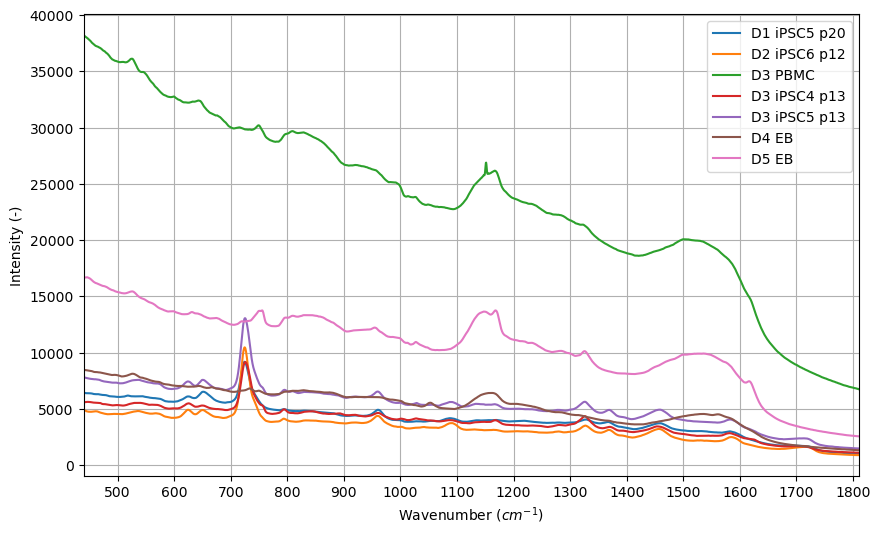

In [30]:
for i in range(len(y_key)):
    plt.plot(wns, X[y==i].mean(axis=0), label=y_key[i])
plt.margins(x=0)
plt.legend()

plt.xticks(range(500, 1801, 100))

plt.grid()
plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (-)")

Text(0, 0.5, 'Intensity (-)')

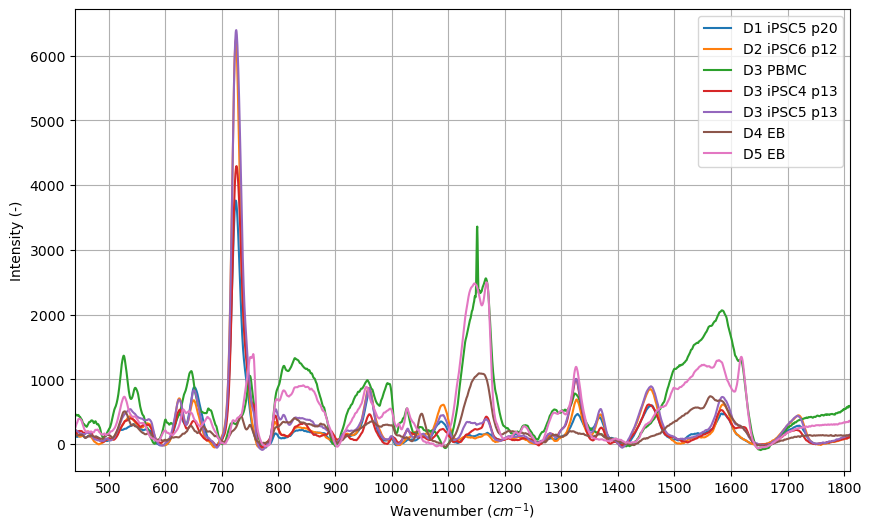

In [31]:
X_bl = BaselineCorrector().fit_transform(X)

for i in range(len(y_key)):
    plt.plot(wns, X_bl[y==i].mean(axis=0), label=y_key[i])
plt.margins(x=0)
plt.legend()

plt.xticks(range(500, 1801, 100))

plt.grid()
plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (-)")

Text(0, 0.5, 'Intensity (-)')

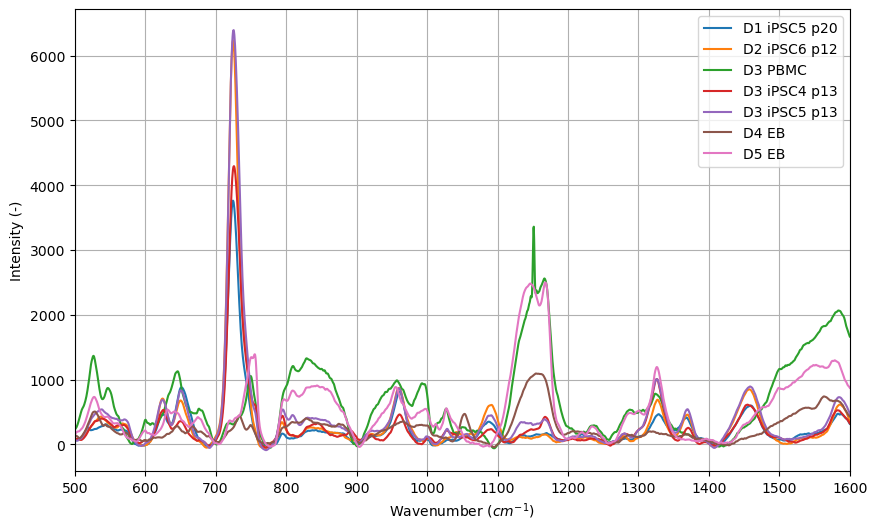

In [32]:
rl = RangeLimiter(lim=(wn_min, wn_max), reference=wns)
X_rl = rl.fit_transform(X_bl)
wns_reduced = wns[rl.lim_[0]:rl.lim_[1]]

for i in range(len(y_key)):
    plt.plot(wns_reduced, X_rl[y==i].mean(axis=0), label=y_key[i])
plt.margins(x=0)
plt.legend()

plt.xticks(range(500, 1601, 100))

plt.grid()
plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (-)")

Text(0, 0.5, 'Intensity (-)')

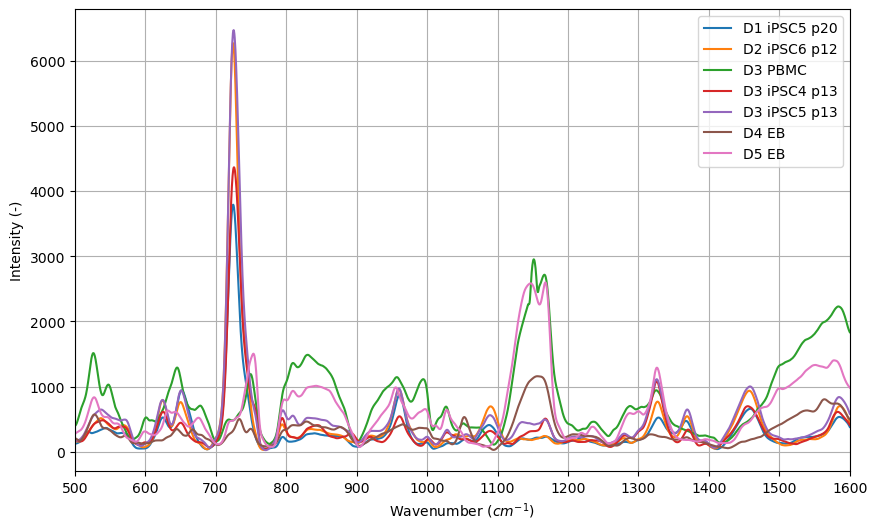

In [33]:
X_smooth = SavGolFilter(window=sg_window).fit_transform(X_rl)

for i in range(len(y_key)):
    plt.plot(wns_reduced, X_smooth[y==i].mean(axis=0), label=y_key[i])
plt.margins(x=0)
plt.legend()

plt.xticks(range(500, 1601, 100))

plt.grid()
plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (-)")

Text(0, 0.5, 'Intensity (-)')

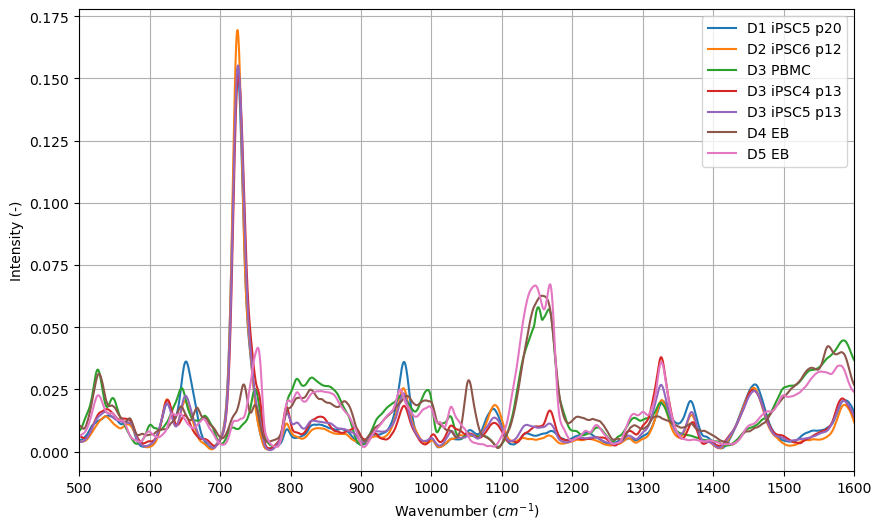

In [34]:


X_norm = Normalizer().fit_transform(X_smooth)

for i in range(len(y_key)):
    plt.plot(wns_reduced, X_norm[y==i].mean(axis=0), label=y_key[i])
plt.margins(x=0)
plt.legend()

plt.xticks(range(500, 1601, 100))

plt.grid()
plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (-)")

In [35]:
n_components = 3

In [36]:
# Run PCA with selected no. of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_norm)

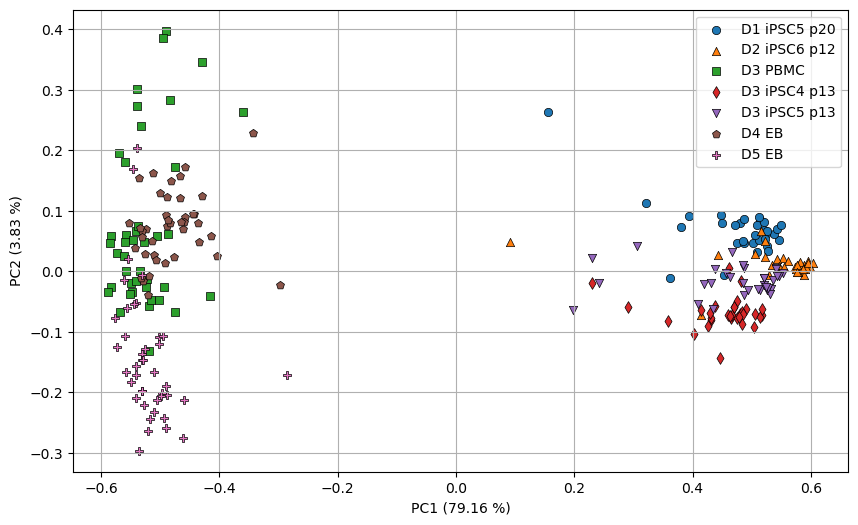

In [37]:
# simple score plot for PC1 and PC2
shapes = ["o", "^", "s", "d", "v", "p", "P", "*", "<", ">"]

for i, marker in zip(range(len(y_key)), cycle(shapes)):
    plt.scatter(X_pca[y==i, 0], X_pca[y==i, 1], label = y_key[i], marker=marker, edgecolors="k", linewidths=0.5)

plt.xlabel(f"PC1 ({(pca.explained_variance_ratio_[0] * 100):.2f} %)")
plt.ylabel(f"PC2 ({(pca.explained_variance_ratio_[1] * 100):.2f} %)")
plt.legend()

plt.grid()

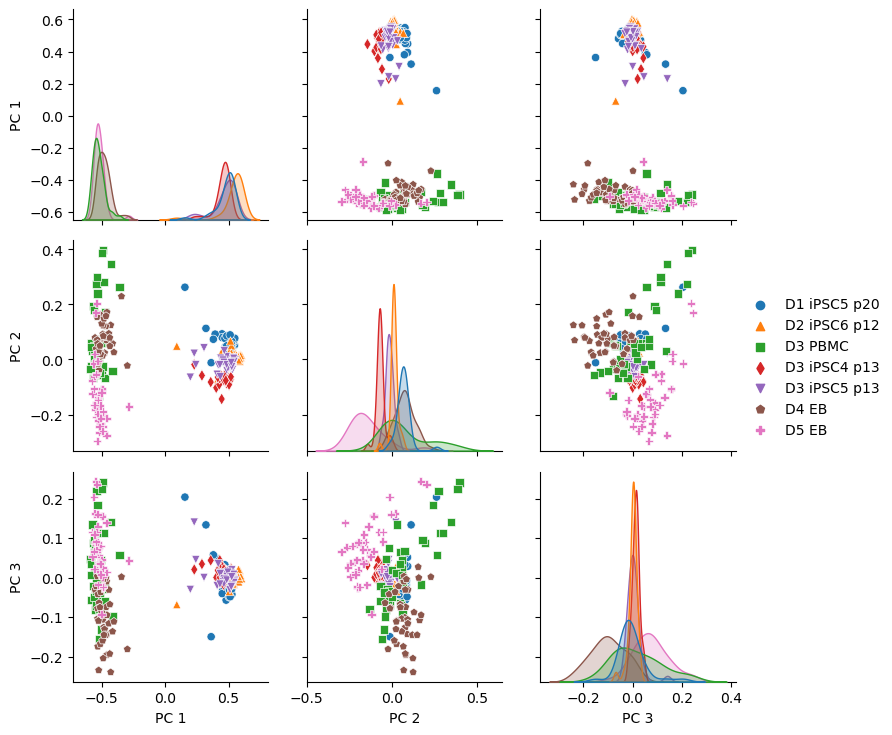

In [38]:
# Pairwise score plot with density plots on the diagonal
plot_data = pd.DataFrame(X_pca, columns=[f"PC {i+1}" for i in range(n_components)])
plot_data.insert(0, "Class", y_key[y])

grid = sns.PairGrid(plot_data, hue="Class", hue_order=y_key)
grid.map_offdiag(sns.scatterplot,
                 style=plot_data["Class"],
                 style_order=y_key,
                 markers=[s for i, s in zip(y_key, cycle(shapes))])
grid.map_diag(sns.kdeplot, fill=True)
grid.set()
grid.add_legend(title="")

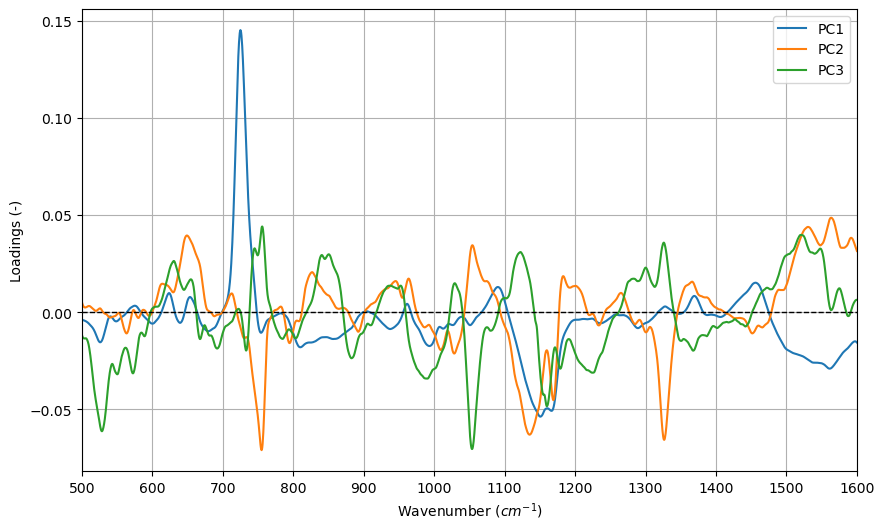

In [39]:
for i, component in enumerate(pca.components_):
    plt.plot(wns_reduced, component, label=f"PC{i+1}")


plt.axhline(y=0, linestyle="--", linewidth=1, color="k")

plt.margins(x=0)

plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Loadings (-)")

plt.xticks(range(500, 1601, 100))

plt.legend()

plt.grid()